In [1]:
import glob,pickle,csv,cv2,os,random
import numpy as np 
import pandas as pd 
from pathlib import Path

import matplotlib.pyplot as plt
from PIL import Image
from keras.preprocessing import image
from keras.utils import np_utils
from keras.applications import InceptionV3
from keras.optimizers import Adam
from keras.layers import Dense, Activation, Flatten, Input,Dropout
from keras.models import Model
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from time import gmtime, strftime

%matplotlib inline

In [2]:
!nvidia-smi

Sun May  2 05:10:35 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.06    Driver Version: 450.51.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!nvcc -V

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Wed_Jul_22_19:09:09_PDT_2020
Cuda compilation tools, release 11.0, V11.0.221
Build cuda_11.0_bu.TC445_37.28845127_0


In [4]:
feature_dir = f"/kaggle/input/aoidl"
train_csv="../input/aoidl/train.csv"
train_path="../input/aoidl/train_images/train_images/"
test_csv="../input/aoidl/test.csv"
test_path="../input/aoidl/test_images/test_images/"

In [5]:
#訓練集並做正規化
img_name=pd.read_csv(train_csv)['ID']
img_data_list=[]

for img in img_name:
    img_path=train_path+img
    IMG=image.load_img(img_path,target_size=(150,150))
    x=image.img_to_array(IMG)
    x=np.expand_dims(x,axis=0)
    x=x/255.0
    img_data_list.append(x)

img_data = np.array(img_data_list)

print (img_data.shape)  
img_data=np.rollaxis(img_data,1,0)
print (img_data.shape) 
img_data=img_data[0]
print (img_data.shape)

(2528, 1, 150, 150, 3)
(1, 2528, 150, 150, 3)
(2528, 150, 150, 3)


In [6]:
#設定標籤值
data=pd.read_csv(train_csv)
num_classes=6
labels=data['Label']
Y=np_utils.to_categorical(labels,num_classes)
x,y=shuffle(img_data,Y,random_state=2)

#訓練集80%、驗證集20%
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=15)

print (x_train.shape)
print (x_test.shape)
print (y_train.shape)
print (y_test.shape)

(2022, 150, 150, 3)
(506, 150, 150, 3)
(2022, 6)
(506, 6)


In [7]:
def show_train(train_history,train,validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.xlabel('Epoch')
    plt.ylabel(train)
    plt.legend(['train','validation'],loc='upper left')
    plt.show()

In [8]:
#使用InceptionV3進行模型訓練
image_input=Input(shape=(150,150,3))
model=InceptionV3(include_top=False, weights='imagenet', input_shape=(150,150,3),input_tensor=image_input)

last_layer = model.output
last_layer=Dropout(0.25)(last_layer)
last_layer=Flatten()(last_layer)
last_layer=Dropout(0.5)(last_layer)
out = Dense(num_classes, activation='softmax')(last_layer)

custom_V3_model = Model(image_input, out)
#custom_V3_model.summary()

87916544/87910968 [==============================] - 1s 0us/step


In [9]:
custom_V3_model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=1e-4),metrics=['accuracy']) #Adam(lr=1e-5)
train_history=custom_V3_model.fit(x_train,y_train,validation_data=(x_test,y_test),batch_size=32,epochs=20,verbose=1)

Epoch 1/20
64/64 [==============================] - 19s 133ms/step - loss: 1.3356 - accuracy: 0.5625 - val_loss: 1.6618 - val_accuracy: 0.5672
Epoch 2/20
64/64 [==============================] - 6s 90ms/step - loss: 0.1880 - accuracy: 0.9308 - val_loss: 0.8281 - val_accuracy: 0.7787
Epoch 3/20
64/64 [==============================] - 6s 94ms/step - loss: 0.0964 - accuracy: 0.9728 - val_loss: 0.4167 - val_accuracy: 0.8715
Epoch 4/20
64/64 [==============================] - 6s 91ms/step - loss: 0.0517 - accuracy: 0.9872 - val_loss: 0.2419 - val_accuracy: 0.9229
Epoch 5/20
64/64 [==============================] - 6s 91ms/step - loss: 0.0412 - accuracy: 0.9841 - val_loss: 0.1773 - val_accuracy: 0.9407
Epoch 6/20
64/64 [==============================] - 6s 90ms/step - loss: 0.0332 - accuracy: 0.9913 - val_loss: 0.0864 - val_accuracy: 0.9723
Epoch 7/20
64/64 [==============================] - 6s 91ms/step - loss: 0.0315 - accuracy: 0.9906 - val_loss: 0.0730 - val_accuracy: 0.9743
Epoch 8/20


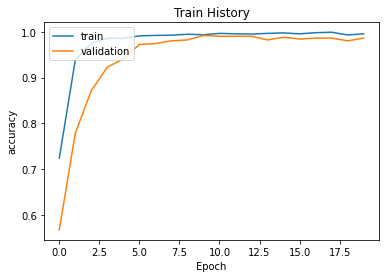

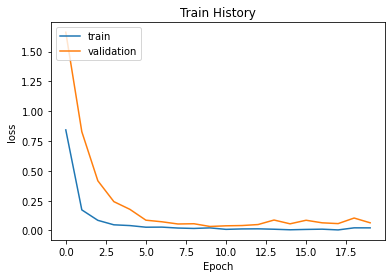

In [10]:
show_train(train_history,'accuracy','val_accuracy')
show_train(train_history,'loss','val_loss')

In [11]:
#測試集並做正規化
test_data_path=pd.read_csv(test_csv)["ID"]
test_img_list=[]
for img in test_data_path:
    test_IMG=image.load_img(test_path+img,target_size=(150,150))
    x=image.img_to_array(test_IMG)
    x=np.expand_dims(x,axis=0)
    x=x/255.0
    test_img_list.append(x)

test_img_data = np.array(test_img_list)
  
print (test_img_data.shape)  
test_img_data=np.rollaxis(test_img_data,1,0)
print (test_img_data.shape)  
test_img_data=test_img_data[0]
print (test_img_data.shape)

(10142, 1, 150, 150, 3)
(1, 10142, 150, 150, 3)
(10142, 150, 150, 3)


In [12]:
#預測測試集
prediction=custom_V3_model.predict(test_img_data)
predict=np.argmax(prediction,axis=1)
sub=pd.read_csv(test_csv)
sub['Label']=predict
sub.head()


,ID,Label
0,test_00000.png,1
1,test_00001.png,2
2,test_00002.png,5
3,test_00003.png,3
4,test_00004.png,2


In [13]:
sub.to_csv("./sub"+strftime("_%m_%d_%H_%M", gmtime())+".csv",index=False)